In [186]:
import pickle
import sys
import numpy as np
import pandas as pd
import re
from tqdm import tqdm_notebook, trange
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing
import nltk

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
sys.path.append('/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src')

In [3]:
import imp
import tokenizer
import w2v_preprocessing
imp.reload(w2v_preprocessing)

<module 'w2v_preprocessing' from '/Users/ak/Yandex.Disk.localized/sentiment-neural_past_from_Denis_Kirjanov/src/w2v_preprocessing.py'>

In [59]:

#from transformer import TopFrequentWordsIndexer
import transformer
imp.reload(transformer)
from nltk_sent_tokenize_binding import NLTKSentenceTokenizer

Что можно сделать по word2vec:
1. Разобраться, что делать с незнакомыми словами
2. Выбрать частоту отсечения для словаря
3. Разбить текст на предложения (каждому сопоставить источник и метку тональности)
4. Учесть смайлики.

In [5]:
#df = pd.read_csv('/Users/ak/Yandex.Disk.localized/sentiment_from_Denis_Kirjanov/sentiment/data/data_all.csv')
df = pd.read_csv('/Users/ak/Yandex.Disk.localized/sentiment_from_Denis_Kirjanov/sentiment/data/data_all.csv', 
                dtype={'text':str, 'score':np.int16, 'source':str})
df.dropna(inplace=True, subset=['text'])

In [6]:
lemmatizer = w2v_preprocessing.Lemmatizer()
model = transformer.TopFrequentWordsIndexer(vocabulary_size=50000, lemmatizer=lemmatizer)

Разобьем текст на предложения. Для каждого предложения записываем оценку и источник соответствующего текста

Ранее использовался самописный вариант, теперь - продвинутый через обертку над NLTK

In [62]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/ak/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def split_text(text):
    pass

In [79]:
df.shape

(92236, 3)

In [83]:
sentences = []
scores = []
sources = []
regex = re.compile('\.\s|\?\s|\!\s|\.+|\.(?=\w)')
false_stoppings = ["лат", "греч", "проц", "млн", "млрд", "итал", "фр", "рус", "кв", "м", "тыс", "руб", "англ", "п",
                       "ст", "гор", "обл", "пос", "д", "дер", "др", "пр", "рег", "ул", "к", "т.е", "т.п", "юр", "физ"]
sentence_tokenizer = NLTKSentenceTokenizer(false_stoppings)
progress_bar = tqdm_notebook(total=df.shape[0])
for text, score, source in zip(df.text.values, df.score.values, df.source.values):
    for sentence in text.split('\n'):
        s = sentence_tokenizer(sentence)
        sentences.extend(s)
        scores.extend([score for x in s])
        sources.extend([source for x in s])
    progress_bar.update(1)
progress_bar.close()

HBox(children=(IntProgress(value=0, max=92236), HTML(value='')))

Самописный вариант:

sentences = []
scores = []
sources = []
regex = re.compile('\.\s|\?\s|\!\s|\.+|\.(?=\w)')

for text, score, source in tqdm_notebook(zip(df.text.values, df.score.values, df.source.values)):
    s = regex.split(text)
    if s:
        sentences.extend(s)
        scores.extend([score for x in s])
        sources.extend([source for x in s])
    else:
        sentences.append(text)
        scores.append(score)
        sources.append(source)

In [84]:
len(sentences)

586643

Сохраним датафрейм с предложениями

In [85]:
data_sentences = pd.DataFrame({'text':sentences, 'score':scores, 'source':sources})
data_sentences.to_csv('data_sentences.csv', encoding='utf-8')

Обучим модель и получим векторные представления

In [141]:
%%time
X_idx = model.fit_transform(sentences)

Converting to lowercase...
lemmatizing
CPU times: user 3min 53s, sys: 30.1 s, total: 4min 23s
Wall time: 4min 32s


In [130]:
model.transform(['закрыли перед носом дверь и послали всех далеко и надолго'])

Converting to lowercase...
lemmatizing


[[277, 2136, 587, 990, 3, 380, 4161]]

In [11]:
import pickle
with open('model_tokenize.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('data_tokenized.pkl', 'wb') as f:
    pickle.dump(X_idx, f)

Нарисуем распределение длин предложений (по представлениям)

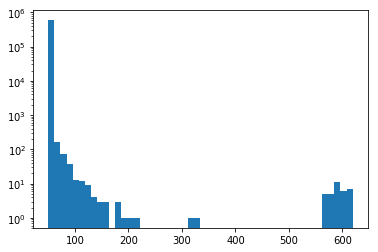

In [134]:
lengths = [len(x) for x in X_idx]
_ = plt.hist(lengths, bins=50)
plt.gca().set_yscale('log')

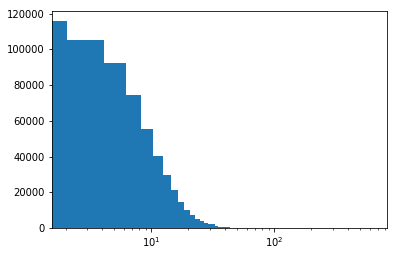

In [97]:
_ = plt.hist(lengths, bins=300)
plt.gca().set_xscale('log')

Выведем наиболее длинные предложения

In [94]:
regex = re.compile('\.\s|\?\s|\!\s|\.{3,}|\.(?=[^\W\d])|\n')
for i, emb in enumerate(X_idx):
    if len(emb) > 50:
        #s = regex.split(sentences[i])
        print(sentences[i])
        #print(s)
        print('-'*100)

чтобы этого избежать - пишите сразу же в офисе компании заявление на выдачу полиса ОСАГО (либо на их бланке, либо в произвольной форме (типа: Прошу заключить договор обязательного страхования в соответствии с Федеральным законом « Об обязательном страховании гражданской ответственности владельцев транспортных средств» на срок действия с « __» ___ 20__ г. по « __» ___ 20__ г. В случае отказа прошу дать мотивированный ответ в установленные законодательством сроки) на листочке бумаги), не слушая менеджера - что авто нужно осмотреть, а у нас на это очередь (никто ничего осматривать не будет, они просто пугают, тем более по правилам ОСАГО п.19 - осмотр авто должен производиться по месту жительства).
----------------------------------------------------------------------------------------------------
00 мы уже были в офисе и сидели в очереди ( когда мы появились на пороге менеджер буркнула "сейчас начнут качать права", скуксилась и за грустила))) обслужив 3 клиентов очередь дошла до мужчины, 

<br /><br />Также в рамках Конгресса состоялась презентация журнала МАНО « Непрерывное профессиональное образование»  <br /><br />Организационный комитет Международного Конгресса &quot; Дополнительное профессиональное образование в высшей школе&quot; выражает благодарность:<br />-           Полномочному представителю Президента РФ в Южном федеральном округе Устинову Владимиру Васильевичу<br />-           Губернатору Ростовской области Голубеву Василию Юрьевичу<br />-         Директору Департамента государственной политики в сфере подготовки рабочих кадров и ДПО Минобрнауки России Золотаревой Наталии Михайловне ﻿
----------------------------------------------------------------------------------------------------
Министр связи и массовых коммуникаций Николай Никифоров согласился с этим, но сообщил, что министерство прорабатывает идею распространить подобные обременения не только на желающих строить LTE в диапазоне 1800 МГц, но и на других операторов: для диапазона ниже 1 ГГц предполагает

Подсчитаем квантили для распределения длин представлений

In [90]:
quantiles = np.arange(start=50, stop=100, step=1)
for q in quantiles:
    print(q, np.percentile(np.array(lengths), q))

50 6.0
51 6.0
52 6.0
53 6.0
54 7.0
55 7.0
56 7.0
57 7.0
58 7.0
59 7.0
60 7.0
61 8.0
62 8.0
63 8.0
64 8.0
65 8.0
66 8.0
67 9.0
68 9.0
69 9.0
70 9.0
71 9.0
72 10.0
73 10.0
74 10.0
75 10.0
76 11.0
77 11.0
78 11.0
79 11.0
80 12.0
81 12.0
82 12.0
83 13.0
84 13.0
85 13.0
86 14.0
87 14.0
88 15.0
89 15.0
90 16.0
91 16.0
92 17.0
93 18.0
94 19.0
95 20.0
96 21.0
97 23.0
98 26.0
99 31.0


In [93]:
np.percentile(np.array(lengths), 99.8)

45.0

In [105]:
def pad_sequence(seq, max_len=50, fillvalue=0):
    if len(seq) < max_len:
        seq.extend([fillvalue for i in range(max_len - len(seq))])
    return seq
    

In [111]:
pool = multiprocessing.Pool(2)

Process ForkPoolWorker-17:
Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/Users/ak/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ak/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ak/anaconda3/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/ak/anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/Users/ak/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last):
  File "/Users/ak/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/ak/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ak/anacon

In [112]:
%%time
X_idx_padded = pool.map(pad_sequence, X_idx)

CPU times: user 3.2 s, sys: 1.53 s, total: 4.73 s
Wall time: 5.57 s


In [113]:
%%time
X_idx_padded2 = []
for x in X_idx:
    X_idx_padded2.append(pad_sequence(x))

CPU times: user 171 ms, sys: 9.68 ms, total: 180 ms
Wall time: 179 ms


In [116]:
for i in range(len(X_idx)):
    assert X_idx_padded[i] == X_idx_padded2[i]

In [117]:
model.vocab_size

50000

In [118]:
def get_ngrams(sentence, context_size):
    seq = []
    for i in range(len(sentence) - context_size):
        seq.append((sentence[i:i + context_size], sentence[i + context_size]))
    return seq

In [120]:
get_ngrams([1,2,3,4,5,6,7], 2)

[([1, 2], 3), ([2, 3], 4), ([3, 4], 5), ([4, 5], 6), ([5, 6], 7)]

In [121]:
sequences = []
for x in tqdm_notebook(X_idx):
    sequences.extend(get_ngrams(x, 3))

HBox(children=(IntProgress(value=0, max=586643), HTML(value='')))

In [122]:
sequences[:10]

[([227, 106, 1944], 227),
 ([106, 1944, 227], 106),
 ([1944, 227, 106], 48),
 ([227, 106, 48], 121),
 ([106, 48, 121], 0),
 ([48, 121, 0], 0),
 ([121, 0, 0], 0),
 ([0, 0, 0], 0),
 ([0, 0, 0], 0),
 ([0, 0, 0], 0)]

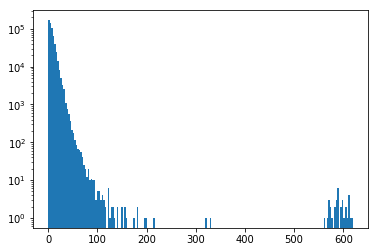

In [142]:
lengths = [len(x) for x in X_idx]
_ = plt.hist(lengths, bins=200)
plt.gca().set_yscale('log')

(0, 40)

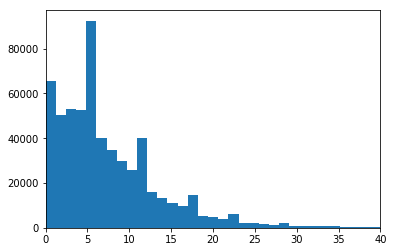

In [149]:
lengths = [len(x) for x in X_idx]
_ = plt.hist(lengths, bins=510)
plt.xlim([0, 40])
#plt.gca().set_yscale('log')

In [139]:
data_sentences.shape

(586643, 3)

In [140]:
data_sentences.head()

,score,source,text
0,5,foursquare,"2 рабочих места, выделенное рабочее место по к..."
1,5,foursquare,"pos-терминал, сенсорный экран для управления ""..."
2,5,foursquare,очереди имеются.
3,5,foursquare,"free wi-fi ""tattelecom_unlim"" :) good while wa..."
4,5,foursquare,so pretty interior though


In [143]:
min(lengths)

0

In [144]:
batch_size = 256
window = 3

In [171]:
def get_sequences(seq, context_size):
    padded_seq = [0 for i in range(context_size)]
    padded_seq.extend(seq)
    #print(padded_seq)
    contexts = []
    for i in range(len(seq)):
        contexts.append(padded_seq[i:i + context_size])
    return contexts

In [164]:
seq = model.transform([data_sentences.loc[0, 'text']])[0]
print(seq)
contexts = get_sequences(seq, 4)
print(contexts)

Converting to lowercase...
lemmatizing
[222, 106, 1949, 222, 106, 48, 123]
[0, 0, 0, 0, 222, 106, 1949, 222, 106, 48, 123]
[[0, 0, 0, 0], [0, 0, 0, 222], [0, 0, 222, 106], [0, 222, 106, 1949], [222, 106, 1949, 222], [106, 1949, 222, 106], [1949, 222, 106, 48]]


In [ ]:
sequences = 
for x in X_idx:
    

In [153]:
data_sentences.loc[0, 'text']

'2 рабочих места, выделенное рабочее место по кредитам, 1 касса.'

Попробуем получить контексты $w_{t+1}$, $w_{t+2}$, ...

In [169]:
print(seq)
list(reversed(get_sequences(list(reversed(seq)), 3)))

[222, 106, 1949, 222, 106, 48, 123]
[0, 0, 0, 123, 48, 106, 222, 1949, 106, 222]


[[222, 1949, 106],
 [106, 222, 1949],
 [48, 106, 222],
 [123, 48, 106],
 [0, 123, 48],
 [0, 0, 123],
 [0, 0, 0]]

Попробуем получить контексты для каждого слова. 

Так как применяется заполнение нулями слева и справа на длину контекста, то для каждого слова в предложении определены и контекст после, и контекст перед

In [172]:
pre_contexts = []
post_contexts = []
targets = []
context_size = 3
for x in tqdm_notebook(X_idx):
    pre_context = get_sequences(x, context_size)
    post_context = list(reversed(get_sequences(list(reversed(x)), context_size)))
    pre_contexts.extend(pre_context)
    post_contexts.extend(post_context)
    targets.extend(x)

HBox(children=(IntProgress(value=0, max=586643), HTML(value='')))

Попробуем получить вариант в numpy

In [172]:
pre_contexts = []
post_contexts = []
targets = []
context_size = 3
for x in tqdm_notebook(X_idx):
    pre_context = get_sequences(x, context_size)
    post_context = list(reversed(get_sequences(list(reversed(x)), context_size)))
    pre_contexts.extend(pre_context)
    post_contexts.extend(post_context)
    targets.extend(x)

HBox(children=(IntProgress(value=0, max=586643), HTML(value='')))

In [178]:
len(pre_contexts) 

4505790

In [176]:
len(pre_context)

3

In [177]:
len(targets)

4505790

In [248]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime, timedelta
from  IPython.display import clear_output


Загрузим датасет в тензоры

In [180]:
pre = torch.LongTensor(pre_contexts)

In [181]:
post = torch.LongTensor(post_contexts)

In [184]:
context = torch.cat([pre, post], dim=1)
context.shape

torch.Size([4505790, 6])

In [185]:
target = torch.LongTensor(targets)
target.shape

torch.Size([4505790])

In [187]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [238]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size=128):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim * 2 * context_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, inputs):
        #print(inputs.shape)
        embeds = self.embeddings(inputs)
        #print(embeds.shape)
        out = self.linear1(embeds.view(-1, embedding_dim * 2 * context_size))
        #print(out.shape)
        out = F.relu(out)
        out = self.linear2(out)
        #print(out.shape)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [239]:
context_size * embedding_dim

192

In [246]:
timedelta(minutes=2)

datetime.timedelta(0, 120)

In [ ]:
embedding_dim = 64
word2vec = NGramLanguageModeler(model.vocab_size, embedding_dim, context_size)
losses = []
loss_function = nn.NLLLoss()
optimizer = optim.SGD(word2vec.parameters(), lr=0.001)
num_epochs = 10
batch_size = 2**12
t_start = datetime.now()
tstep = timedelta(seconds=30)
plt.figure()
for epoch in tqdm_notebook(range(1)):
    total_loss = torch.Tensor([0])
    for X, y in iterate_minibatches(context, target, batch_size):
        word2vec.zero_grad()
        X = Variable(X)
        y = Variable(y)
        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = word2vec(X)
        

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a variable)
        #print(log_probs.shape, y.shape)
        loss = loss_function(log_probs, y)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()
        losses.append(loss.data.numpy())
        total_loss += loss.data
        #print(loss.data)
        if datetime.now() - t_start > tstep:
            #clear_output()
            #plt.clf()
            plt.plot(losses)
            plt.grid()
            t_start = datetime.now()
    #losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!
plt.plot(losses)

In [219]:
X.shape, y.shape

(torch.Size([256, 6]), torch.Size([256]))

In [202]:
393216 / 256 / 256

6.0

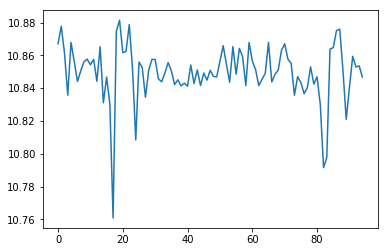

In [252]:
plt.plot(losses)